In [1]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()

Saving DS.zip to DS.zip


In [2]:
import zipfile
import os

# Path to the uploaded zip file (you can use the filename from the upload step)
zip_file_path = '/content/DS.zip'  # Replace with your actual file name
extracted_folder_path = '/content/extracted_data/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List the extracted files to confirm successful extraction
extracted_files = os.listdir(extracted_folder_path)
print(f"Extracted files: {extracted_files}")

Extracted files: ['train', 'test']


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [4]:
train_dir = os.path.join(extracted_folder_path, 'train')
test_dir = os.path.join(extracted_folder_path, 'test')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and preprocessing for the training dataset
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255  # Normalize pixel values between 0 and 1
)

# Load training data from the directory
train_data = train_datagen.flow_from_directory(
    directory='/content/extracted_data/train',  # Directory path for training data
    target_size=(128, 128),  # Resize images to 128x128 pixels
    batch_size=32,
    class_mode='categorical'  # For multi-class classification
)

# Get the class indices (mapping from class labels to their respective index)
print(train_data.class_indices)

Found 28709 images belonging to 7 classes.
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values between 0 and 1

# Load validation data from the directory
val_data = val_datagen.flow_from_directory(
    directory='/content/extracted_data/test',  # Directory path for the test data
    target_size=(128, 128),  # Resize images to 128x128 pixels
    batch_size=32,
    class_mode='categorical'  # For multi-class classification
)

# Get the class indices (mapping from class labels to their respective index)
print(val_data.class_indices)

Found 7178 images belonging to 7 classes.
{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


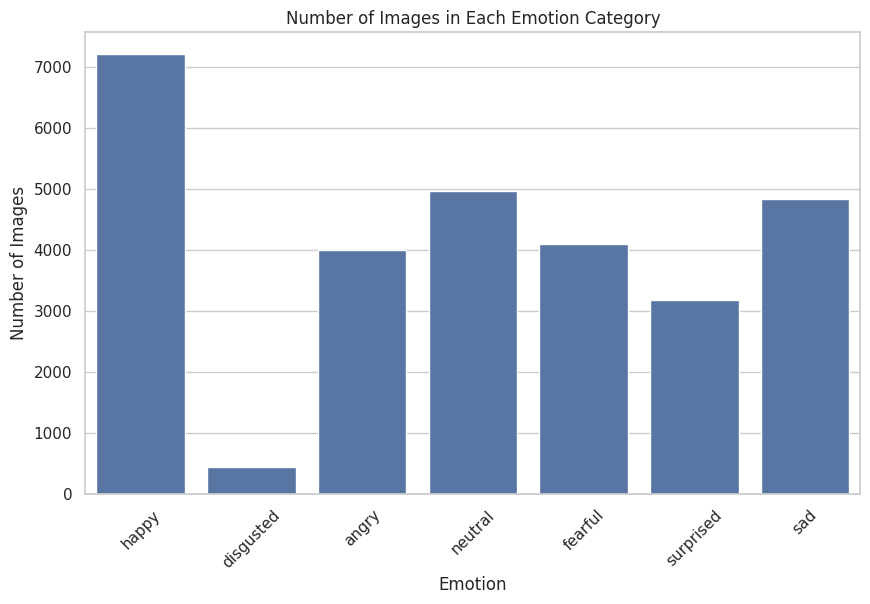

In [7]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the 'train' directory in the extracted folder
path = '/content/extracted_data/train'

# List all the emotions (subfolders) in the train directory
emotions = os.listdir(path)

# Initialize lists to store folder names and the count of images
folder_names = []
counts = []

# Loop through each emotion folder and count the number of images
for emotion in emotions:
    emotion_path = os.path.join(path, emotion)
    num_images = len(os.listdir(emotion_path))  # Get number of images in each class folder

    folder_names.append(emotion)
    counts.append(num_images)

# Plot the number of images in each emotion category
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=folder_names, y=counts)
ax.set(xlabel='Emotion', ylabel='Number of Images')
plt.title('Number of Images in Each Emotion Category')
plt.xticks(rotation=45)  # Rotate labels if they overlap
plt.show()

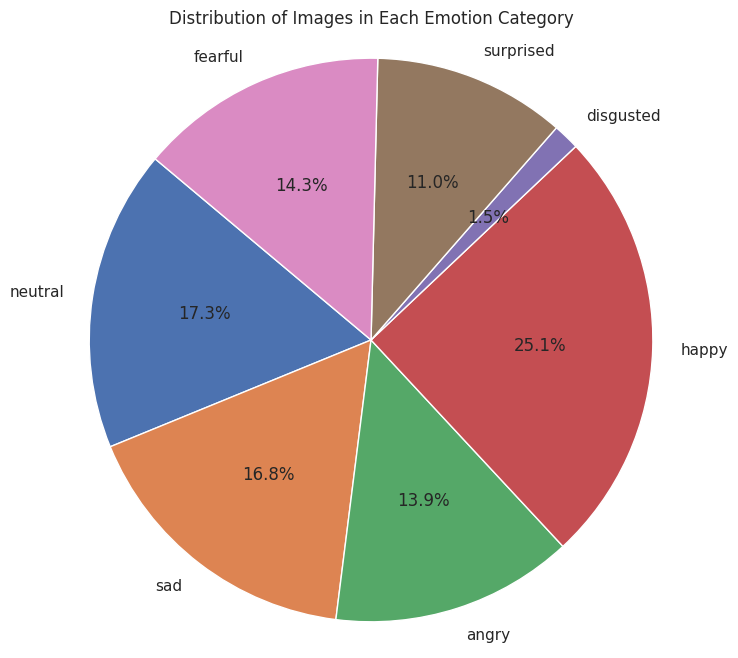

In [ ]:
# Plot the distribution of images as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=folder_names, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Images in Each Emotion Category')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

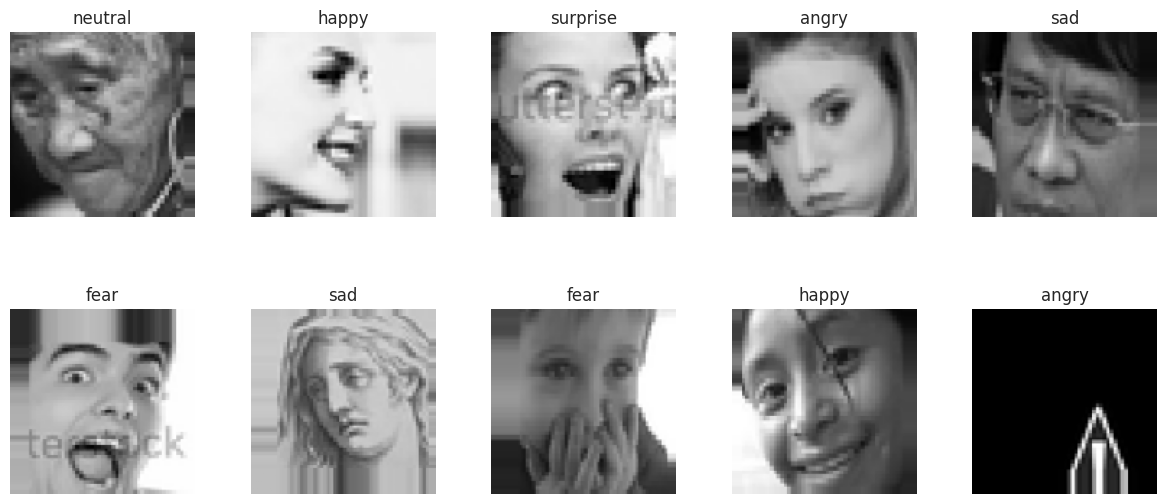

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training data using next()
t_img, label = next(train_data)

def plotImages(img_arr, one_hot_labels, label_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.5)

    for i, (im, one_hot_label) in enumerate(zip(img_arr, one_hot_labels)):
        label_index = np.argmax(one_hot_label)  # Get the index of the max value in one-hot label
        label_name = label_names[label_index]  # Get the corresponding label name

        ax = axes[i // 5, i % 5]
        ax.imshow(im)  # Display the image
        ax.set_title(label_name)  # Set the title to the label name
        ax.axis('off')  # Turn off axis for better visualization

        if i == 9:  # Only display 10 images (2 rows, 5 columns)
            break

# Define the class labels (emotion categories)
label_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Plot images from the batch
plotImages(t_img, label, label_names)


CNN


In [ ]:
# --------------------------
# Imports
# --------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os

# --------------------------
# Device configuration
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------
# Paths and Hyperparameters
# --------------------------
train_path = '/content/extracted_data/train'
val_path = '/content/extracted_data/test'
batch_size = 8
num_epochs = 15
learning_rate = 3e-4
model_save_path = 'best_model.pth'

# --------------------------
# Transforms
# --------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --------------------------
# Datasets and DataLoaders
# --------------------------
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# --------------------------
# CNN Model Definition
# --------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> (32, 64, 64)
        x = self.pool(F.relu(self.conv2(x)))  # -> (64, 32, 32)
        x = self.pool(F.relu(self.conv3(x)))  # -> (128, 16, 16)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleCNN(num_classes=len(train_dataset.classes))
model.to(device)

# --------------------------
# Loss and Optimizer
# --------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --------------------------
# Training and Validation Loop
# --------------------------
cnn_best_val_accuracy = 0.0  # To track the highest validation accuracy

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)

    # Update best validation accuracy and save model
    if val_accuracy > cnn_best_val_accuracy:
        cnn_best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_save_path)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val   Loss: {avg_val_loss:.4f} | Val   Accuracy: {val_accuracy:.2f}%")
    print("-" * 50)

print(f"\nBest Validation Accuracy: {cnn_best_val_accuracy:.2f}%")
print(f"Best model saved to: {model_save_path}")


Using device: cuda
Epoch [1/15]
Train Loss: 1.5069 | Train Accuracy: 41.12%
Val   Loss: 1.3047 | Val   Accuracy: 49.71%
--------------------------------------------------
Epoch [2/15]
Train Loss: 1.1985 | Train Accuracy: 54.27%
Val   Loss: 1.2224 | Val   Accuracy: 53.00%
--------------------------------------------------
Epoch [3/15]
Train Loss: 0.9623 | Train Accuracy: 64.39%
Val   Loss: 1.1884 | Val   Accuracy: 55.41%
--------------------------------------------------
Epoch [4/15]
Train Loss: 0.6747 | Train Accuracy: 75.69%
Val   Loss: 1.3200 | Val   Accuracy: 55.07%
--------------------------------------------------
Epoch [5/15]
Train Loss: 0.3741 | Train Accuracy: 87.00%
Val   Loss: 1.7106 | Val   Accuracy: 54.08%
--------------------------------------------------
Epoch [6/15]
Train Loss: 0.1777 | Train Accuracy: 94.34%
Val   Loss: 2.3911 | Val   Accuracy: 54.01%
--------------------------------------------------
Epoch [7/15]
Train Loss: 0.1162 | Train Accuracy: 96.62%
Val   Loss: 

ResNet

In [ ]:
# --------------------------
# ResNet18 Model with Max Accuracy Tracking
# --------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_path = '/content/extracted_data/train'
val_path = '/content/extracted_data/test'
batch_size = 8
num_epochs = 15
learning_rate = 3e-4
model_save_path = 'best_resnet18_model.pth'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Load pretrained ResNet18 and modify final layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --------------------------
# Track best validation accuracy
# --------------------------
resnet_best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"[Epoch {epoch+1}] Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"          Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")
    print('-' * 50)

    # Save best model
    if val_acc > resnet_best_val_acc:
        resnet_best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)

print(f"\nBest Validation Accuracy: {resnet_best_val_acc:.2f}%")
print(f"Best model saved to: {model_save_path}")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


[Epoch 1] Train Loss: 1.2566, Train Acc: 52.46%
          Val Loss: 1.1329, Val Acc: 57.29%
--------------------------------------------------
[Epoch 2] Train Loss: 1.0640, Train Acc: 60.45%
          Val Loss: 1.0433, Val Acc: 60.32%
--------------------------------------------------
[Epoch 3] Train Loss: 0.9299, Train Acc: 65.51%
          Val Loss: 0.9680, Val Acc: 64.61%
--------------------------------------------------
[Epoch 4] Train Loss: 0.7769, Train Acc: 71.66%
          Val Loss: 0.9810, Val Acc: 65.30%
--------------------------------------------------
[Epoch 5] Train Loss: 0.5934, Train Acc: 78.72%
          Val Loss: 0.9990, Val Acc: 66.16%
--------------------------------------------------
[Epoch 6] Train Loss: 0.4079, Train Acc: 85.61%
          Val Loss: 1.1724, Val Acc: 65.74%
--------------------------------------------------
[Epoch 7] Train Loss: 0.2670, Train Acc: 90.91%
          Val Loss: 1.4040, Val Acc: 63.99%
--------------------------------------------------

MobileNet CNN

In [9]:
# --------------------------
# Imports
# --------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# --------------------------
# Device configuration
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------
# Paths and Hyperparameters
# --------------------------
train_path = '/content/extracted_data/train'
val_path = '/content/extracted_data/test'
batch_size = 8
num_epochs = 15
learning_rate = 3e-4
model_save_path = 'best_mobilenetv2_model.pth'

# --------------------------
# Transforms
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNetV2 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

# --------------------------
# Datasets and DataLoaders
# --------------------------
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# --------------------------
# Load MobileNetV2
# --------------------------
model = models.mobilenet_v2(pretrained=True)

# Replace classifier with one suited for our dataset
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(train_dataset.classes))

model = model.to(device)

# --------------------------
# Loss and Optimizer
# --------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --------------------------
# Training and Validation Loop
# --------------------------
mobilenet_best_val_accuracy = 0.0  # Track best validation accuracy

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)

    # Save the model if it has the best validation accuracy so far
    if val_accuracy > mobilenet_best_val_accuracy:
        mobilenet_best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_save_path)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val   Loss: {avg_val_loss:.4f} | Val   Accuracy: {val_accuracy:.2f}%")
    print("-" * 50)

print(f"\nBest Validation Accuracy: {mobilenet_best_val_accuracy:.2f}%")
print(f"Best model saved to: {model_save_path}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Using device: cuda


100%|██████████| 13.6M/13.6M [00:00<00:00, 107MB/s] 


Epoch [1/15]
Train Loss: 1.2545 | Train Accuracy: 52.39%
Val   Loss: 1.1047 | Val   Accuracy: 59.06%
--------------------------------------------------
Epoch [2/15]
Train Loss: 1.0755 | Train Accuracy: 59.73%
Val   Loss: 1.0238 | Val   Accuracy: 62.48%
--------------------------------------------------
Epoch [3/15]
Train Loss: 0.9815 | Train Accuracy: 63.70%
Val   Loss: 1.0045 | Val   Accuracy: 63.19%
--------------------------------------------------
Epoch [4/15]
Train Loss: 0.9069 | Train Accuracy: 66.20%
Val   Loss: 0.9600 | Val   Accuracy: 64.46%
--------------------------------------------------
Epoch [5/15]
Train Loss: 0.8303 | Train Accuracy: 69.29%
Val   Loss: 0.9654 | Val   Accuracy: 64.86%
--------------------------------------------------
Epoch [6/15]
Train Loss: 0.7646 | Train Accuracy: 71.72%
Val   Loss: 0.9705 | Val   Accuracy: 64.22%
--------------------------------------------------
Epoch [7/15]
Train Loss: 0.6992 | Train Accuracy: 74.02%
Val   Loss: 1.0063 | Val   Accu

Vision Transfer

In [10]:
# --------------------------
# Imports
# --------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm

# --------------------------
# Device configuration
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------
# Paths and Hyperparameters
# --------------------------
train_path = '/content/extracted_data/train'
val_path = '/content/extracted_data/test'
batch_size = 8
num_epochs = 15
learning_rate = 3e-4
model_save_path = 'best_vit_model.pth'

# --------------------------
# Transforms
# --------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --------------------------
# Datasets and DataLoaders
# --------------------------
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# --------------------------
# Load Vision Transformer
# --------------------------
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))
model.to(device)

# --------------------------
# Loss and Optimizer
# --------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --------------------------
# Training and Validation Loop
# --------------------------
vit_best_val_accuracy = 0.0  # Track best validation accuracy

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)

    # --------------------------
    # Validation
    # --------------------------
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)

    # Save best model
    if val_accuracy > vit_best_val_accuracy:
        vit_best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), model_save_path)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val   Loss: {avg_val_loss:.4f} | Val   Accuracy: {val_accuracy:.2f}%")
    print("-" * 50)

print(f"\nBest Validation Accuracy: {vit_best_val_accuracy:.2f}%")
print(f"Best model saved to: {model_save_path}")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch [1/15]
Train Loss: 1.5856 | Train Accuracy: 37.14%
Val   Loss: 1.4254 | Val   Accuracy: 44.36%
--------------------------------------------------
Epoch [2/15]
Train Loss: 1.3428 | Train Accuracy: 48.24%
Val   Loss: 1.3204 | Val   Accuracy: 48.77%
--------------------------------------------------
Epoch [3/15]
Train Loss: 1.2521 | Train Accuracy: 51.71%
Val   Loss: 1.2571 | Val   Accuracy: 51.00%
--------------------------------------------------
Epoch [4/15]
Train Loss: 1.1743 | Train Accuracy: 55.20%
Val   Loss: 1.2052 | Val   Accuracy: 54.14%
--------------------------------------------------
Epoch [5/15]
Train Loss: 1.1088 | Train Accuracy: 57.63%
Val   Loss: 1.1893 | Val   Accuracy: 53.82%
--------------------------------------------------
Epoch [6/15]
Train Loss: 1.0564 | Train Accuracy: 59.97%
Val   Loss: 1.1349 | Val   Accuracy: 56.90%
--------------------------------------------------
Epoch [7/15]
Train Loss: 1.0017 | Train Accuracy: 61.94%
Val   Loss: 1.1339 | Val   Accu